In [0]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.pandas as ps
from math import *
from haversine import haversine, Unit

In [0]:
df = spark.read.table("fordgobike_tripdata_2017_csv")
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: integer (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: integer (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



In [0]:
# define the haversine function as udf
def haversine(lat1, lon1, lat2, lon2):
    R = 6372.8  # Earth radius in kilometers

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat / 2)**2 + cos(lat1) * cos(lat2) * sin(dLon / 2)**2
    c = 2 * asin(sqrt(a))

    return R * c

# register the UDF
haversine_udf = udf(haversine)

# calculate the distance and add a new column to the dataset
df = df.withColumn("distance", haversine_udf("start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"))


In [0]:
df = df.withColumn("member_birth_date", to_date(col("member_birth_year").cast("string"), "yyyy"))
df = df.withColumn("age", year(current_date()) - year(col("member_birth_date")))

In [0]:
df = df.dropna(subset=["age", "distance"])
df = df.withColumn("distance", col("distance")*1000)
df_sel=df.select(["age","distance"])

In [0]:
pdf = df_sel.select("age","distance").filter((col("age") < 65)&(col("age")>18)).toPandas()

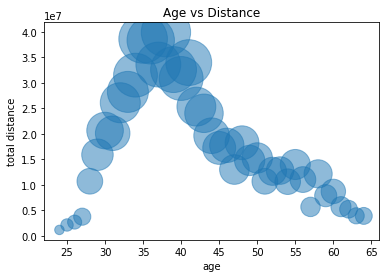

In [0]:
import matplotlib.pyplot as plt

grouped_pdf = pdf.groupby("age").agg({"distance": "sum", "age": "count"}).rename(columns={"age": "count"})
plt.scatter(grouped_pdf.index, grouped_pdf["distance"], s=grouped_pdf["count"]*0.10, alpha=0.5)

#plt.scatter(pdf["age"], pdf["distance"], s=0.5, alpha=0.5)
plt.xlabel("age")
plt.ylabel("total distance")
plt.title("Age vs Distance")
plt.show()